In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

np.random.seed(1337)
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000

# Data

In [2]:
# load the training data from the respective filepaths
train_features_filepath = 'data/train_features.csv'
test_features_filepath = 'data/test_features.csv'
train_labels_filepath = 'data/train_labels.csv'

# create the dataframes
train_features_df = pd.read_csv(train_features_filepath, float_precision="round_trip")
test_features_df = pd.read_csv(test_features_filepath, float_precision="round_trip")
train_labels_df = pd.read_csv(train_labels_filepath, float_precision="round_trip")
print("Train shape:", train_features_df.shape, "| Train label shape:", train_labels_df.shape, "| Test shape:", test_features_df.shape)
display(train_features_df.head(40))
display(train_labels_df.head(40))
display(test_features_df.head(30))

display(train_features_df.describe())
display(train_labels_df.describe())

Train shape: (227940, 37) | Train label shape: (18995, 16) | Test shape: (151968, 37)


,pid,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
0,1,3,34.0,NaN,NaN,12.0,NaN,36.0,8.7,24.0,-2.0,16.0,NaN,NaN,6.3,NaN,45.0,NaN,NaN,NaN,NaN,NaN,84.0,1.2,3.8,61.0,NaN,NaN,100.0,NaN,114.0,24.6,94.0,NaN,NaN,142.0,7.33
1,1,4,34.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,-2.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,81.0,NaN,NaN,62.5,NaN,NaN,100.0,NaN,NaN,NaN,99.0,NaN,NaN,125.0,7.33
2,1,5,34.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,0.0,18.0,NaN,NaN,NaN,NaN,43.0,NaN,0.4,NaN,NaN,NaN,74.0,NaN,NaN,59.0,NaN,NaN,100.0,NaN,NaN,NaN,92.0,NaN,NaN,110.0,7.37
3,1,6,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,0.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,NaN,NaN,49.5,NaN,NaN,100.0,NaN,NaN,NaN,88.0,NaN,NaN,104.0,7.37
4,1,7,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,1.8,NaN,48.0,NaN,NaN,100.0,NaN,NaN,22.4,81.0,NaN,NaN,100.0,7.41
5,1,8,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,68.0,1.8,NaN,51.0,NaN,NaN,100.0,NaN,NaN,22.4,82.0,NaN,NaN,106.0,NaN
6,1,9,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,NaN,NaN,46.0,NaN,NaN,100.0,NaN,NaN,NaN,67.0,NaN,NaN,112.0,NaN
7,1,10,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN,NaN,47.0,NaN,NaN,100.0,NaN,NaN,NaN,62.0,NaN,NaN,121.0,NaN
8,1,11,34.0,NaN,NaN,12.0,NaN,NaN,8.5,26.0,NaN,12.0,NaN,4.6,4.7,0.50,NaN,NaN,NaN,143.0,NaN,120.0,67.0,2.1,4.1,47.0,7.60,NaN,100.0,NaN,111.0,23.8,58.0,NaN,NaN,118.0,NaN
9,1,12,34.0,NaN,NaN,12.0,NaN,38.0,8.5,26.0,0.0,18.0,NaN,NaN,4.7,NaN,42.0,NaN,0.4,NaN,NaN,NaN,62.0,2.1,4.1,44.0,NaN,NaN,100.0,NaN,111.0,23.8,66.0,NaN,NaN,110.0,7.39


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.1,85.4,100.0,59.9
1,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.8,100.6,95.5,85.5
2,100,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16.5,88.3,96.5,108.1
3,1000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,19.4,77.2,98.3,80.9
4,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.6,76.8,97.7,95.3
5,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,67.4,99.1,64.6
6,10006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.2,84.9,96.8,90.5
7,10007,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,23.8,97.0,94.3,76.0
8,10009,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,18.9,72.0,95.3,91.5
9,1001,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14.9,83.3,99.9,117.3


,pid,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
0,0,1,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,39.0,NaN,44.2,17.0,NaN,36.0,10.2,13.0,NaN,NaN,147.0,6.0,17.5,2.2,NaN,32.0,0.60,194.0,NaN,273.0,77.0,2.2,4.60,76.0,8.00,119.0,100.0,NaN,98.0,31.0,82.0,21.8,NaN,119.0,NaN
2,0,3,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.0,13.0,NaN,NaN,NaN,NaN,26.0,NaN,0.55,NaN,NaN,NaN,78.0,NaN,NaN,72.5,NaN,NaN,100.0,NaN,NaN,NaN,78.0,NaN,NaN,125.0,7.34
3,0,4,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,87.0,NaN,NaN,66.0,NaN,NaN,100.0,NaN,NaN,NaN,80.0,NaN,NaN,136.0,NaN
4,0,5,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,NaN,NaN,65.0,NaN,NaN,100.0,NaN,NaN,NaN,83.0,NaN,NaN,135.0,NaN
5,0,6,39.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0,NaN,NaN,66.0,NaN,NaN,100.0,NaN,NaN,NaN,88.0,NaN,NaN,144.0,NaN
6,0,7,39.0,NaN,38.5,20.0,NaN,NaN,9.1,16.0,NaN,12.0,NaN,4.8,18.5,2.4,NaN,31.0,0.50,193.0,NaN,162.0,NaN,2.5,3.70,NaN,8.30,109.0,100.0,NaN,102.0,25.9,NaN,26.4,NaN,NaN,NaN
7,0,8,39.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,-4.0,12.0,NaN,NaN,NaN,NaN,30.0,NaN,0.50,NaN,NaN,NaN,80.0,NaN,NaN,59.0,NaN,NaN,100.0,NaN,NaN,NaN,90.0,NaN,NaN,129.0,7.40
8,0,9,39.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,NaN,NaN,56.5,NaN,NaN,100.0,NaN,NaN,NaN,90.0,NaN,NaN,121.0,NaN
9,0,10,39.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,NaN,NaN,55.0,NaN,NaN,100.0,NaN,NaN,NaN,85.0,NaN,NaN,120.0,NaN


,pid,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
count,227940.000000,227940.000000,227940.000000,9783.000000,10299.000000,20105.000000,10756.000000,81115.000000,22295.000000,12559.00000,19887.000000,187785.000000,2493.000000,11590.000000,19083.000000,17792.000000,21043.000000,5761.000000,26602.000000,18035.000000,13014.000000,47036.000000,195889.000000,17523.000000,28393.000000,152418.000000,17830.000000,5708.000000,195192.000000,719.000000,13917.000000,27297.000000,200128.000000,5326.000000,3776.000000,191650.000000,25046.000000
mean,15788.831219,7.014399,62.073809,32.883114,40.091310,23.192664,2.859716,36.852136,10.628208,23.48810,-1.239284,18.154043,262.496911,3.612519,11.738649,1.495777,41.115696,193.444888,0.701666,204.666426,93.010527,142.169407,82.117276,2.004149,4.152729,64.014711,7.161149,97.796163,97.663449,1.390723,106.260185,31.283090,84.522371,1.640941,7.269240,122.369877,7.367231
std,9151.896286,4.716103,16.451854,7.802065,26.034961,20.024289,2.428368,0.875152,2.074859,4.40378,4.192677,5.037031,133.020910,1.384462,10.088872,1.898112,8.929873,682.836708,24.522126,104.156406,10.887271,56.894530,16.471871,0.437286,0.670168,13.920097,2.812067,122.773379,2.786186,2.792722,5.916082,5.770425,17.643437,3.244145,25.172442,23.273834,0.074384
min,1.000000,1.000000,15.000000,10.000000,12.500000,1.000000,0.200000,21.000000,3.300000,0.00000,-29.000000,1.000000,34.000000,0.200000,0.100000,0.100000,10.000000,5.000000,0.000000,2.000000,24.000000,15.000000,20.000000,0.500000,1.300000,20.000000,1.000000,12.000000,20.000000,0.010000,66.000000,9.400000,23.000000,0.100000,0.010000,21.000000,6.820000
25%,7879.000000,4.000000,52.000000,28.500000,27.800000,12.000000,1.400000,36.000000,9.200000,21.00000,-3.000000,15.000000,177.000000,2.800000,7.600000,0.700000,36.000000,21.000000,0.400000,137.000000,95.000000,108.000000,71.000000,1.700000,3.700000,54.250000,7.300000,53.000000,96.000000,0.100000,103.000000,27.300000,72.000000,0.500000,0.030000,105.000000,7.330000
50%,15726.000000,7.000000,64.000000,33.000000,32.200000,17.000000,2.100000,37.000000,10.500000,23.90000,-1.000000,18.000000,233.000000,3.400000,10.400000,0.900000,40.000000,36.000000,0.500000,189.000000,97.000000,130.000000,80.000000,2.000000,4.100000,62.000000,8.200000,72.000000,98.000000,0.300000,107.000000,30.900000,83.000000,0.800000,0.150000,119.000000,7.370000
75%,23725.000000,10.000000,74.000000,38.000000,40.600000,27.000000,3.400000,37.000000,12.000000,26.00000,0.000000,21.000000,316.000000,4.200000,14.000000,1.380000,45.000000,84.000000,0.600000,251.000000,98.000000,160.000000,91.000000,2.200000,4.500000,72.000000,8.700000,104.000000,100.000000,1.210000,110.000000,35.000000,95.000000,1.400000,2.050000,137.000000,7.410000
max,31658.000000,315.000000,100.000000,100.000000,250.000000,268.000000,31.000000,42.000000,23.800000,50.00000,100.000000,97.000000,1179.000000,16.400000,440.000000,41.900000,100.000000,9961.000000,4000.000000,2322.000000,100.000000,952.000000,300.000000,9.600000,10.750000,298.000000,20.600000,3833.000000,100.000000,21.200000,141.000000,63.400000,191.000000,46.500000,440.000000,287.000000,7.780000


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
count,18995.000000,18995.000000,18995.000000,18995.000000,18995.00000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000
mean,15788.831219,0.268281,0.073704,0.239747,0.23622,0.240590,0.200211,0.099763,0.233693,0.033904,0.066017,0.057278,18.795960,82.511171,96.947311,84.119716
std,9152.117122,0.443076,0.261295,0.426940,0.42477,0.427453,0.400168,0.299692,0.423190,0.180986,0.248319,0.232380,3.511241,12.745110,2.110957,14.718396
min,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,26.000000,27.000000,30.200000
25%,7879.500000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.550000,73.200000,95.900000,73.700000
50%,15726.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.400000,81.000000,97.100000,83.400000
75%,23724.500000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.600000,90.200000,98.300000,93.600000
max,31658.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,41.100000,147.100000,100.000000,155.600000


## Outliers removal

In [3]:
print(train_labels_df.shape, "| features:", train_features_df.shape)

outlier_columns = [col for col in train_features_df.columns if col not in ['pid', 'Time', 'Age']]

df = train_features_df[outlier_columns]
train_features_df[outlier_columns] = df[df.fillna(df.median()).apply(lambda x: np.abs(x - x.mean()) / x.std() < 5).all(axis=1)]

print(train_labels_df.shape, "| features:", train_features_df.shape)

(18995, 16) | features: (227940, 37)
(18995, 16) | features: (227940, 37)


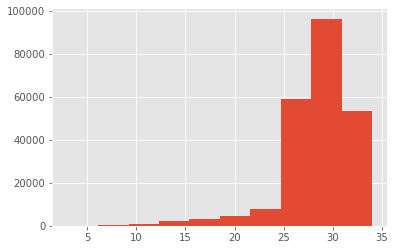

'Number of instances: 227940'

In [4]:
import matplotlib.pyplot as plt

# Plots the number of rows that have 'NaN' values
plt.style.use('ggplot')
plt.hist(train_features_df.isnull().sum(axis=1), bins=10)
plt.show()

display("Number of instances: {}".format(train_features_df.shape[0]))

In [5]:
labels_sepsis_positive = train_labels_df.loc[train_labels_df['LABEL_Sepsis'] == 1]
display(labels_sepsis_positive.describe())
display(labels_sepsis_positive.head(100))

#temp_grouped = group_columns_in_df(train_features_df)
#display(temp_grouped.head(10))
#features_sepsis_positive = temp_grouped.loc[temp_grouped['pid'].isin(labels_sepsis_positive['pid'])]
#scale_df(features_sepsis_positive)
#display(features_sepsis_positive.describe())

,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
count,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.0,1088.000000,1088.000000,1088.000000,1088.000000
mean,15935.926471,0.547794,0.177390,0.465993,0.460478,0.469669,0.605699,0.129596,0.511949,0.100184,0.189338,1.0,19.881541,80.647059,97.036397,88.546599
std,9166.983876,0.497939,0.382174,0.499072,0.498665,0.499309,0.488925,0.336012,0.500087,0.300383,0.391957,0.0,4.631534,11.236957,2.451813,14.966026
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,51.800000,67.000000,49.800000
25%,8043.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,16.700000,72.800000,95.900000,78.175000
50%,16180.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,19.500000,79.550000,97.400000,87.800000
75%,23941.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,22.500000,88.000000,98.600000,98.325000
max,31515.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,36.900000,125.300000,100.000000,134.700000


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
7,10007,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,23.8,97.0,94.3,76.0
20,10023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,13.3,80.3,96.7,78.0
25,10030,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,17.9,85.3,99.8,95.2
27,10034,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,16.1,89.2,99.7,65.4
31,10038,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,18.4,62.0,97.1,81.1
35,10048,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,18.4,95.5,97.6,98.6
53,10072,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,15.7,78.8,97.6,91.7
83,10116,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,15.8,91.2,99.3,74.9
93,10130,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,20.6,78.2,97.0,101.8
109,10150,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,18.1,72.8,97.9,67.0


## Grouping

* groupby the `'pid'` column values for each age range from `[0, 20, 30, 40, 50, 60, 70, 80, 110]`
* ignore `'Time'` col

In [6]:
def group_columns_in_df(df):
    age_ranges = [0, 20, 30, 40, 50, 60, 70, 80, 110]
    dfs = []
    for i in range(len(age_ranges) - 1):
        age_l = age_ranges[i]
        age_u = age_ranges[i+1]
        sub_df = df[(df['Age'] >= age_l) & (df['Age'] < age_u)]
        sub_df = sub_df.loc[:, sub_df.columns != 'Time'].groupby('pid', as_index=False, sort=False).agg(np.median)
        sub_df = sub_df.fillna(sub_df.median())
        dfs.append(sub_df)
    grouped_df = df.loc[:, df.columns != 'Time'].groupby('pid', as_index=False, sort=False).agg(np.nanmedian)
    result = grouped_df.copy()
    result.update(result[['pid']].merge(pd.concat(dfs)))
    result = result.astype({"pid": int})
    assert(grouped_df.shape == result.shape)
    assert(not grouped_df.equals(result))
    return result

X_df = group_columns_in_df(train_features_df)
display(X_df.shape)
display(X_df.head(20))

X_test_df = group_columns_in_df(test_features_df)

(18995, 36)

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
0,1,34.0,34.000,28.900,12.0,1.700,37.0,8.500,26.0,0.0,18.0,239.50,4.6,4.70,0.50,42.5,31.0,0.40,143.0,98.0,120.00,67.0,1.95,4.1,48.0,7.60,66.5,100.0,0.2,111.0,22.40,69.0,0.7,0.030,110.0,7.380
1,10,71.0,32.500,31.400,17.0,1.825,36.0,10.400,24.0,-1.0,16.0,229.00,3.3,10.00,0.90,40.0,27.0,0.50,176.0,98.0,130.00,101.5,2.00,4.1,82.5,8.40,63.0,98.0,0.2,108.0,30.80,78.0,0.7,0.105,136.0,7.380
2,100,68.0,33.125,20.900,21.0,1.700,36.0,12.500,27.0,-0.5,15.0,215.00,3.5,12.50,1.10,40.5,27.5,0.50,204.0,98.0,243.00,80.0,1.70,3.6,63.0,9.00,65.0,97.0,0.2,101.0,36.80,113.0,0.7,0.095,113.0,7.380
3,1000,79.0,30.000,31.400,22.0,1.825,37.0,9.200,24.0,-1.0,12.0,229.00,1.9,19.60,0.96,40.0,27.0,0.50,158.0,98.0,170.75,84.0,2.00,4.3,65.0,8.10,63.0,100.0,0.2,108.0,27.30,79.0,0.7,0.105,144.0,7.380
4,10000,76.0,32.500,28.550,22.0,1.825,37.0,10.700,25.5,1.5,12.0,229.00,3.3,7.75,1.00,44.0,27.0,0.50,135.0,98.0,121.75,68.0,1.40,3.9,49.5,8.40,63.0,98.0,0.2,103.5,30.30,75.0,0.7,0.105,130.0,7.395
5,10002,73.0,32.500,31.400,17.0,1.825,37.0,10.400,24.0,-1.0,19.0,229.00,3.3,10.00,0.90,40.0,27.0,0.50,176.0,98.0,119.00,66.0,2.00,4.1,48.0,8.40,63.0,100.0,0.2,108.0,30.80,70.0,0.7,0.105,129.0,7.380
6,10006,51.0,33.500,30.650,13.0,1.700,37.5,10.850,24.0,0.0,20.0,223.00,3.4,10.20,0.82,40.0,30.0,0.50,189.0,98.0,200.50,71.0,1.95,4.0,49.0,8.35,62.0,96.0,0.2,107.0,31.90,83.0,0.7,0.060,122.0,7.380
7,10007,60.0,33.125,31.200,15.0,1.700,38.0,10.500,24.0,-0.5,22.0,215.00,2.4,10.10,0.86,40.5,27.5,0.50,184.0,98.0,87.00,114.0,1.60,3.6,91.0,8.30,65.0,94.0,0.2,107.0,31.10,89.0,0.7,0.080,146.0,7.380
8,10009,69.0,33.125,31.200,15.0,1.700,37.0,10.500,24.0,-0.5,23.0,215.00,3.3,10.10,0.86,40.5,27.5,0.50,184.0,98.0,129.50,68.0,2.00,4.1,67.0,8.30,65.0,97.0,0.2,107.0,31.10,98.0,0.7,0.095,90.0,7.380
9,1001,36.0,34.000,28.900,11.0,1.700,37.0,11.175,24.0,4.0,12.0,239.50,3.3,10.10,0.80,40.5,31.0,0.40,205.5,98.0,118.00,88.0,1.90,3.9,70.0,8.40,66.5,100.0,0.2,107.0,29.70,108.0,0.7,0.030,116.0,7.350


## Adding features

In [7]:
def max_abs_diff_agg_fn(x):
    if x.isna().all():
        return 0
    else:
        min_val = np.nanmin(x)
        max_val = np.nanmax(x)
        res = np.abs(max_val - min_val)
        return res

def std_dev_agg_fn(x):
    if x.isna().all():
        return 0
    else:
        return np.nanstd(x)
    
def min_agg_fn(x):
    if x.isna().all():
        return np.nan
    else:
        return np.nanmin(x)
    
def max_agg_fn(x):
    if x.isna().all():
        return np.nan
    else:
        return np.nanmax(x)


def add_features(df_to_group, df_to_add_features_to):
    """Add maximum absolute difference features for each column to a dataframe
    
    Args:
        df_to_group (pd.DataFrame): the dataframe that will be grouped by 'pid'
        df_to_add_features_to (pd.DataFrame): the dataframe to add new features to
        
    Returns:
        pd.DataFrame: the new dataframe with all features
    """
    grouped_df = df_to_group.drop(['Age', 'Time'], axis=1).groupby('pid', as_index=False, sort=False)
    ## Maximum Absolute Difference
    mad_features_df = grouped_df.agg(max_abs_diff_agg_fn)
    #mad_features_df = grouped_df.agg(np.nanmean)
    mad_features_df.columns = [str(col) + '_diff' for col in mad_features_df.columns]
    # Remove 'pid' col from features_df
    mad_features_df = mad_features_df.iloc[:, 1:]
    
    ## Std dev.
    std_features_df = grouped_df.agg(std_dev_agg_fn)
    #std_features_df = grouped_df.agg(np.nanmean)
    std_features_df.columns = [str(col) + '_std' for col in std_features_df.columns]
    # Remove 'pid' col from features_df
    std_features_df = std_features_df.iloc[:, 1:]
    
    ## Min
    min_features_df = grouped_df.agg(min_agg_fn)
    #min_features_df = grouped_df.agg(np.nanmean)
    min_features_df.columns = [str(col) + '_min' for col in min_features_df.columns]
    # Remove 'pid' col from features_df
    min_features_df = min_features_df.iloc[:, 1:]
    
    ## Max
    max_features_df = grouped_df.agg(max_agg_fn)
    #max_features_df = grouped_df.agg(np.nanmean)
    max_features_df.columns = [str(col) + '_max' for col in max_features_df.columns]
    # Remove 'pid' col from features_df
    max_features_df = max_features_df.iloc[:, 1:]
    
    ## Fever
    df_to_add_features_to['Fever'] = df_to_add_features_to.apply(lambda row: 1 if row['Temp'] >= 37.5 else 0, axis=1)
    
    ## Result
    return pd.concat([
        df_to_add_features_to, 
        mad_features_df, 
        min_features_df,
        max_features_df, 
        std_features_df
    ], axis=1, sort=False)

X_df = add_features(train_features_df, X_df)

display(X_df.shape)
display(X_df.describe())
display(X_df.head(30))

X_test_df = add_features(test_features_df, X_test_df)

X_df_backup = X_df.copy()
X_test_df_backup = X_test_df.copy()

(18995, 173)

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,Fever,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
count,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.00000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,1122.000000,3493.000000,6746.000000,2381.000000,18263.000000,7411.000000,3562.000000,4627.000000,18751.000000,477.000000,3785.000000,6529.000000,6381.000000,5022.000000,1690.000000,6002.000000,6618.000000,2875.00000,11835.000000,18829.000000,5932.000000,8126.000000,15033.000000,5327.000000,1671.000000,18898.000000,200.000000,3659.000000,8608.000000,18929.000000,1615.000000,1690.000000,18532.000000,5285.000000,1122.000000,3493.000000,6746.000000,2381.000000,18263.000000,7411.000000,3562.000000,4627.000000,18751.000000,477.000000,3785.000000,6529.000000,6381.000000,5022.000000,1690.000000,6002.000000,6618.000000,2875.000000,11835.000000,18829.000000,5932.000000,8126.000000,15033.000000,5327.000000,1671.000000,18898.000000,200.000000,3659.000000,8608.000000,18929.000000,1615.000000,1690.000000,18532.000000,5285.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,189

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,Fever,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
0,1,34.0,34.000,28.900,12.0,1.700,37.0,8.500,26.0,0.0,18.0,239.50,4.6,4.70,0.500,42.5,31.0,0.40,143.0,98.0,120.00,67.0,1.95,4.10,48.00,7.60,66.5,100.0,0.2,111.0,22.40,69.0,0.7,0.030,110.0,7.380,0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,6.0,0.0,0.0,0.0,0.00,1.0,0.0,0.1,0.0,0.0,0.0,28.0,0.3,0.0,23.5,0.0,0.0,0.0,0.0,0.0,1.6,41.0,0.0,0.0,25.0,0.08,NaN,NaN,12.0,NaN,36.0,8.5,26.0,-2.0,12.0,NaN,4.6,4.7,0.50,42.0,NaN,0.40,143.0,NaN,120.0,53.0,1.8,4.1,39.0,7.6,NaN,100.0,NaN,111.0,22.2,58.0,NaN,NaN,100.0,7.33,NaN,NaN,12.0,NaN,38.0,8.5,26.0,0.0,18.0,NaN,4.6,4.7,0.50,43.0,NaN,0.50,143.0,NaN,120.0,81.0,2.1,4.1,62.5,7.6,NaN,100.0,NaN,111.0,23.8,99.0,NaN,NaN,125.0,7.41,0.000000,0.00,0.000000,0.0,0.638877,0.00,0.000000,0.800000,1.781447,0.0,0.0,0.00,0.000,0.500000,0.0,0.043301,0.0,0.000000,0.000000,6.694021,0.150000,0.000000,6.242682,0.0,0.0,0.000000,0.0,0.000000,0.722219,12.858415,0.0,0.0,8.431543,0.024944
1,10,71.0,32.500,31.400,17.0,1.825,36.0,10.400,24.0,-1.0,16.0,229.00,3.3,10.00,0.900,40.0,27.0,0.50,176.0,98.0,130.00,101.5,2.00,4.10,82.50,8.40,63.0,98.0,0.2,108.0,30.80,78.0,0.7,0.105,136.0,7.380,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,0.0,35.0,0.0,0.0,3.0,0.0,0.0,0.0,19.0,0.0,0.0,39.0,0.00,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.0,NaN,NaN,64.0,NaN,NaN,96.0,NaN,NaN,NaN,69.0,NaN,NaN,113.0,NaN,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,NaN,NaN,99.0,NaN,NaN,99.0,NaN,NaN,NaN,88.0,NaN,NaN,152.0,NaN,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.000000,3.176476,0.0,0.0,0.00,0.000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,10.486181,0.000000,0.000000,10.622617,0.0,0.0,1.095445,0.0,0.000000,0.000000,5.787055,0.0,0.0,11.614215,0.000000
2,100,68.0,33.125,20.900,21.0,1.700,36.0,12.500,27.0,-0.5,15.0,215.00,3.5,12.50,1.100,40.5,27.5,0.50,204.0,98.0,243.00,80.0,1.70,3.60,63.00,9.00,65.0,97.0,0.2,101.0,36.80,113.0,0.7,0.095,113.0,7.380,0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,20.0,0.0,0.0,8.0,0.0,0.0,0.0,37.0,0.0,0.0,61.0,0.00,NaN,20.

In [8]:
X_df = X_df_backup.copy()
X_test_df = X_test_df_backup.copy()

## Data imputation

In [9]:
def median_impute_df(df):
    return df.fillna(df.median())

def impute_min_max_df(df):
    filled_cols = [col for col in X_df if (all([not col.endswith(suffix) for suffix in ['_min', '_max', '_diff', '_std']])) and col != 'pid' and col != 'Age']
    df_filled = df[filled_cols].copy()
    
    min_cols = [col for col in X_df if col.endswith('_min')]
    df_filled.columns = min_cols
    df[min_cols] = df[min_cols].fillna(df_filled)
    
    max_cols = [col for col in X_df if col.endswith('_max')]
    df_filled.columns = max_cols
    df[max_cols] = df[max_cols].fillna(df_filled)
    return df

def impute_df(df):
    summarized_cols = ['_min', '_max', '_diff', '_std', '_25%', '_75%']
    filled_cols = [col for col in X_df if (all([not col.endswith(suffix) for suffix in summarized_cols])) and col != 'pid' and col != 'Age' and col != 'Fever']
    df_filled = df[filled_cols].copy()

    assert(df[filled_cols].equals(df_filled.fillna(df_filled.median())))
    min_cols = [col for col in df if col.endswith('_min')]
    df_filled.columns = min_cols
    df[min_cols] = df[min_cols].fillna(df_filled)

    max_cols = [col for col in df if col.endswith('_max')]
    df_filled.columns = max_cols
    df[max_cols] = df[max_cols].fillna(df_filled)
    return df


"""median_cols = [col for col in X_df if not col.endswith('_max') and not col.endswith('_min')]
display(X_df.head(20))
X_df[median_cols] = median_impute_df(X_df[median_cols].copy())
display(X_df.head(30))
X_df = impute_min_max_df(X_df)
display(X_df.head(30))"""

display("------Train------")
display(X_df.head(20))
X_df = impute_df(X_df)
display(X_df.head(20))
display("------Test------")
X_test_df = impute_df(X_test_df)

"""median_cols = [col for col in X_test_df if not col.endswith('_max') and not col.endswith('_min')]
X_test_df[median_cols] = median_impute_df(X_test_df[median_cols].copy())
X_test_df = impute_min_max_df(X_test_df)"""

'------Train------'

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,Fever,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
0,1,34.0,34.000,28.900,12.0,1.700,37.0,8.500,26.0,0.0,18.0,239.50,4.6,4.70,0.50,42.5,31.0,0.40,143.0,98.0,120.00,67.0,1.95,4.1,48.0,7.60,66.5,100.0,0.2,111.0,22.40,69.0,0.7,0.030,110.0,7.380,0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.1,0.0,0.0,0.0,28.0,0.3,0.0,23.5,0.0,0.0,0.0,0.0,0.0,1.6,41.0,0.0,0.0,25.0,0.08,NaN,NaN,12.0,NaN,36.0,8.5,26.0,-2.0,12.0,NaN,4.6,4.7,0.50,42.0,NaN,0.40,143.0,NaN,120.0,53.0,1.8,4.1,39.0,7.6,NaN,100.0,NaN,111.0,22.2,58.0,NaN,NaN,100.0,7.33,NaN,NaN,12.0,NaN,38.0,8.5,26.0,0.0,18.0,NaN,4.6,4.7,0.50,43.0,NaN,0.50,143.0,NaN,120.0,81.0,2.1,4.1,62.5,7.6,NaN,100.0,NaN,111.0,23.8,99.0,NaN,NaN,125.0,7.41,0.000000,0.00,0.0,0.0,0.638877,0.0,0.0,0.800000,1.781447,0.0,0.0,0.00,0.0,0.500000,0.0,0.043301,0.0,0.000000,0.000000,6.694021,0.15,0.0,6.242682,0.0,0.0,0.000000,0.0,0.0,0.722219,12.858415,0.0,0.0,8.431543,0.024944
1,10,71.0,32.500,31.400,17.0,1.825,36.0,10.400,24.0,-1.0,16.0,229.00,3.3,10.00,0.90,40.0,27.0,0.50,176.0,98.0,130.00,101.5,2.00,4.1,82.5,8.40,63.0,98.0,0.2,108.0,30.80,78.0,0.7,0.105,136.0,7.380,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,0.0,35.0,0.0,0.0,3.0,0.0,0.0,0.0,19.0,0.0,0.0,39.0,0.00,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.0,NaN,NaN,64.0,NaN,NaN,96.0,NaN,NaN,NaN,69.0,NaN,NaN,113.0,NaN,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,NaN,NaN,99.0,NaN,NaN,99.0,NaN,NaN,NaN,88.0,NaN,NaN,152.0,NaN,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,3.176476,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,10.486181,0.00,0.0,10.622617,0.0,0.0,1.095445,0.0,0.0,0.000000,5.787055,0.0,0.0,11.614215,0.000000
2,100,68.0,33.125,20.900,21.0,1.700,36.0,12.500,27.0,-0.5,15.0,215.00,3.5,12.50,1.10,40.5,27.5,0.50,204.0,98.0,243.00,80.0,1.70,3.6,63.0,9.00,65.0,97.0,0.2,101.0,36.80,113.0,0.7,0.095,113.0,7.380,0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,20.0,0.0,0.0,8.0,0.0,0.0,0.0,37.0,0.0,0.0,61.0,0.00,NaN,20.9,21.0,NaN,35.0,12.5,27.0,NaN,13.0,NaN,3.5,12.5,1.10,NaN,NaN,NaN,2

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,Fever,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
0,1,34.0,34.000,28.900,12.0,1.700,37.0,8.500,26.0,0.0,18.0,239.50,4.6,4.70,0.50,42.5,31.0,0.40,143.0,98.0,120.00,67.0,1.95,4.1,48.0,7.60,66.5,100.0,0.2,111.0,22.40,69.0,0.7,0.030,110.0,7.380,0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.1,0.0,0.0,0.0,28.0,0.3,0.0,23.5,0.0,0.0,0.0,0.0,0.0,1.6,41.0,0.0,0.0,25.0,0.08,34.000,28.900,12.0,1.700,36.0,8.500,26.0,-2.0,12.0,239.50,4.6,4.7,0.50,42.0,31.0,0.40,143.0,98.0,120.0,53.0,1.80,4.1,39.0,7.60,66.5,100.0,0.2,111.0,22.20,58.0,0.7,0.030,100.0,7.33,34.000,28.900,12.0,1.700,38.0,8.500,26.0,0.0,18.0,239.50,4.6,4.7,0.50,43.0,31.0,0.50,143.0,98.0,120.0,81.0,2.10,4.1,62.5,7.60,66.5,100.0,0.2,111.0,23.80,99.0,0.7,0.030,125.0,7.41,0.000000,0.00,0.0,0.0,0.638877,0.0,0.0,0.800000,1.781447,0.0,0.0,0.00,0.0,0.500000,0.0,0.043301,0.0,0.000000,0.000000,6.694021,0.15,0.0,6.242682,0.0,0.0,0.000000,0.0,0.0,0.722219,12.858415,0.0,0.0,8.431543,0.024944
1,10,71.0,32.500,31.400,17.0,1.825,36.0,10.400,24.0,-1.0,16.0,229.00,3.3,10.00,0.90,40.0,27.0,0.50,176.0,98.0,130.00,101.5,2.00,4.1,82.5,8.40,63.0,98.0,0.2,108.0,30.80,78.0,0.7,0.105,136.0,7.380,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,0.0,35.0,0.0,0.0,3.0,0.0,0.0,0.0,19.0,0.0,0.0,39.0,0.00,32.500,31.400,17.0,1.825,36.0,10.400,24.0,-1.0,15.0,229.00,3.3,10.0,0.90,40.0,27.0,0.50,176.0,98.0,130.0,83.0,2.00,4.1,64.0,8.40,63.0,96.0,0.2,108.0,30.80,69.0,0.7,0.105,113.0,7.38,32.500,31.400,17.0,1.825,36.0,10.400,24.0,-1.0,23.0,229.00,3.3,10.0,0.90,40.0,27.0,0.50,176.0,98.0,130.0,120.0,2.00,4.1,99.0,8.40,63.0,99.0,0.2,108.0,30.80,88.0,0.7,0.105,152.0,7.38,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,3.176476,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,10.486181,0.00,0.0,10.622617,0.0,0.0,1.095445,0.0,0.0,0.000000,5.787055,0.0,0.0,11.614215,0.000000
2,100,68.0,33.125,20.900,21.0,1.700,36.0,12.500,27.0,-0.5,15.0,215.00,3.5,12.50,1.10,40.5,27.5,0.50,204.0,98.0,243.00,80.0,1.70,3.6,63.0,9.00,65.0,97.0,0.2,101.0,36.80,113.0,0.7,0.095,113.0,7.380,0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,20.0,0.0,

'------Test------'

"median_cols = [col for col in X_test_df if not col.endswith('_max') and not col.endswith('_min')]\nX_test_df[median_cols] = median_impute_df(X_test_df[median_cols].copy())\nX_test_df = impute_min_max_df(X_test_df)"

## Scaling / normalization

In [10]:
from sklearn import preprocessing

# Scale the dataframe
def scale_df(df, scaler=None):
    if scaler is None:
        scaler = preprocessing.MinMaxScaler()
        df.loc[:, df.columns != 'pid'] = scaler.fit_transform(df.loc[:, df.columns != 'pid'])
        return scaler
    else:
        df.loc[:, df.columns != 'pid'] = scaler.transform(df.loc[:, df.columns != 'pid'])
        return scaler

scaler = scale_df(X_df)
display(X_df.describe())
_ = display(X_df.head(30), scaler)

scale_df(X_test_df)

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,Fever,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
count,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.0000

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,Fever,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
0,1,0.223529,0.562500,0.272109,0.234043,0.273349,0.500,0.186047,0.705882,0.583333,0.453333,0.542553,0.900000,0.183267,0.111111,0.596154,0.040351,0.183673,0.338983,0.882353,0.394958,0.323308,0.458333,0.488889,0.260638,0.441748,0.325806,1.000000,0.174312,0.785714,0.070352,0.320896,0.1875,0.001171,0.406977,0.541667,0.0,0.0000,0.000000,0.00,0.000000,0.50,0.000000,0.000000,0.166667,0.176471,0.0,0.0,0.000000,0.00,0.041667,0.0,0.083333,0.000000,0.0000,0.000000,0.271845,0.250000,0.000000,0.286585,0.000000,0.0,0.000000,0.0,0.000000,0.091429,0.401961,0.0,0.0,0.186567,0.333333,0.562500,0.272109,0.234043,0.319829,0.25,0.186047,0.705882,0.416667,0.297297,0.542553,0.900000,0.183267,0.111111,0.576923,0.040351,0.200,0.338983,0.882353,0.404959,0.261905,0.333333,0.500000,0.195876,0.441748,0.330128,1.000000,0.174312,0.785714,0.060302,0.275591,0.1875,0.001171,0.446328,0.333333,0.562500,0.272109,0.234043,0.273349,0.75,0.186047,0.705882,0.583333,0.435897,0.542553,0.900000,0.183267,0.111111,0.603774,0.040351,0.234694,0.338983,0.882353,0.394958,0.318584,0.583333,0.488889,0.388298,0.441748,0.325806,1.000000,0.174312,0.785714,0.140704,0.518248,0.1875,0.001171,0.418079,0.666667,0.000000,0.000000,0.000000,0.000000,0.319438,0.000000,0.000000,0.175623,0.111148,0.0,0.0,0.000000,0.00,0.050000,0.0,0.082489,0.000000,0.000000,0.000000,0.220193,0.250000,0.000000,0.232439,0.000000,0.0,0.000000,0.0,0.000000,0.090277,0.304876,0.0,0.0,0.162399,0.262572
1,10,0.658824,0.468750,0.328798,0.340426,0.301822,0.250,0.480620,0.509804,0.500000,0.400000,0.468085,0.466667,0.394422,0.222222,0.500000,0.033333,0.234694,0.450847,0.882353,0.436975,0.582707,0.500000,0.488889,0.627660,0.538835,0.303226,0.857143,0.174312,0.571429,0.492462,0.388060,0.1875,0.005562,0.558140,0.541667,0.0,0.0000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.235294,0.0,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.359223,0.000000,0.000000,0.426829,0.000000,0.0,0.200000,0.0,0.000000,0.000000,0.186275,0.0,0.0,0.291045,0.000000,0.468750,0.328798,0.340426,0.346482,0.25,0.480620,0.509804,0.500000,0.378378,0.468085,0.466667,0.394422,0.22222

MinMaxScaler(copy=True, feature_range=(0, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

# SVM Training

In [11]:
#X_df = X_df.iloc[0:2000, :]
#train_labels_df = train_labels_df.iloc[0:2000, :]

# Prepare train set
# Assert that the pids are matching in train features / train labels dfs
assert(X_df.iloc[:, 0].astype(int).equals(train_labels_df.iloc[:, 0].astype(int)))

X = X_df.iloc[:, 1:].to_numpy()
y = train_labels_df.iloc[:, 1:].to_numpy()

assert(X.shape[0] == y.shape[0])

In [12]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

model = MultiOutputRegressor(SVR(verbose=True, C=1, epsilon=0.01), n_jobs=-1)

model.fit(X, y)

MultiOutputRegressor(estimator=SVR(C=1, cache_size=200, coef0=0.0, degree=3,
                                   epsilon=0.01, gamma='scale', kernel='rbf',
                                   max_iter=-1, shrinking=True, tol=0.001,
                                   verbose=True),
                     n_jobs=-1)

# Predictions

In [13]:
def predict(df):
    # Create X_predict by removing 'pid' column
    X_predict = df.iloc[:, 1:].to_numpy()
    
    # Predict
    predictions = model.predict(X_predict)
    predictions[:, :-4] = np.divide(1, 1+np.exp(-predictions[:, :-4]))
    
    # Create predictions df
    predict_labels_df = pd.DataFrame(columns=train_labels_df.columns)
    predict_labels_df[['pid']] = df[['pid']]
    predict_labels_df.loc[:, predict_labels_df.columns != 'pid'] = predictions
    
    return predict_labels_df

## Train set

In [14]:
prediction_labels_df = predict(X_df)

print(prediction_labels_df.shape)
display(prediction_labels_df.head(15))
display(train_labels_df.head(15))

(18995, 16)


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,1,0.641604,0.502556,0.502213,0.501488,0.499776,0.510008,0.500867,0.540363,0.498580,0.497470,0.502441,17.220649,73.096291,98.807305,81.020868
1,10,0.501309,0.502029,0.501892,0.501766,0.501756,0.501528,0.502360,0.501922,0.502255,0.501688,0.502194,17.850863,95.299635,97.134007,78.436189
2,100,0.516162,0.499245,0.501502,0.501727,0.499791,0.505996,0.501413,0.499825,0.499557,0.502122,0.502460,17.698322,82.522991,96.782770,97.840252
3,1000,0.502424,0.502512,0.502479,0.502455,0.502437,0.524216,0.499155,0.512547,0.502532,0.760138,0.502506,16.019447,85.785071,97.614129,88.864737
4,10000,0.713232,0.499214,0.497466,0.497511,0.497530,0.497827,0.497442,0.603714,0.499441,0.499155,0.499987,15.917547,70.902698,97.157418,78.806708
5,10002,0.502569,0.502075,0.501154,0.501208,0.501405,0.502046,0.502246,0.503375,0.502054,0.499995,0.501739,19.132112,73.979443,97.786660,71.271732
6,10006,0.497621,0.501698,0.502415,0.502415,0.502481,0.500145,0.502439,0.501742,0.501873,0.499630,0.501774,19.421636,75.149111,95.843621,81.038666
7,10007,0.499652,0.502535,0.506229,0.506809,0.505271,0.498572,0.502549,0.498695,0.502267,0.499776,0.503805,19.826359,99.566580,95.827947,77.948850
8,10009,0.500505,0.502316,0.502743,0.502616,0.502674,0.500197,0.501746,0.500291,0.502265,0.498435,0.502070,20.892866,70.889129,96.472384,92.443690
9,1001,0.584247,0.502545,0.502527,0.503093,0.503167,0.508989,0.502582,0.508293,0.501906,0.502537,0.502824,15.686399,87.094290,98.833972,100.268594


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.1,85.4,100.0,59.9
1,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.8,100.6,95.5,85.5
2,100,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16.5,88.3,96.5,108.1
3,1000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,19.4,77.2,98.3,80.9
4,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.6,76.8,97.7,95.3
5,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,67.4,99.1,64.6
6,10006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.2,84.9,96.8,90.5
7,10007,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,23.8,97.0,94.3,76.0
8,10009,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,18.9,72.0,95.3,91.5
9,1001,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14.9,83.3,99.9,117.3


In [15]:
prediction_labels_df.to_csv('data/prediction_train.csv', index=False, float_format='%.3f')

In [16]:
train_labels_df.to_csv('data/prediction_gold.csv', index=False, float_format='%.3f')

## Test set

In [17]:
prediction_test_labels_df = predict(X_test_df)

print(prediction_test_labels_df.shape)
display(prediction_test_labels_df.head(15))

(12664, 16)


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,0,0.589413,0.509836,0.543454,0.546503,0.529211,0.529135,0.499866,0.517763,0.499440,0.546199,0.503445,14.710013,82.452744,98.912615,83.285194
1,10001,0.496319,0.503287,0.509888,0.511677,0.508346,0.507969,0.501889,0.486365,0.499074,0.547577,0.501339,15.952018,86.246387,98.957136,93.234614
2,10003,0.674027,0.501008,0.501419,0.501737,0.498434,0.512649,0.503882,0.517397,0.496706,0.547397,0.495809,16.440445,80.559382,99.106339,87.474045
3,10004,0.498562,0.502555,0.506128,0.507959,0.503383,0.507137,0.504992,0.482506,0.499014,0.550114,0.498644,14.918532,75.923628,99.131437,83.578808
4,10005,0.509745,0.501257,0.515721,0.516029,0.513140,0.512969,0.501303,0.482217,0.500677,0.544349,0.500661,16.517043,78.002119,99.094055,65.266820
5,10008,0.569298,0.501310,0.512470,0.513337,0.509799,0.529654,0.501477,0.488826,0.500277,0.539967,0.499738,16.328522,88.704940,99.356401,74.070210
6,10011,0.501196,0.498176,0.509073,0.509929,0.507813,0.505212,0.502975,0.489218,0.499971,0.541536,0.498209,15.323636,90.270071,99.534991,73.429752
7,10017,0.492556,0.500044,0.507995,0.510098,0.509148,0.501508,0.503279,0.485400,0.500969,0.537828,0.499789,17.509832,97.295028,99.414758,92.092262
8,10018,0.495266,0.500678,0.506815,0.507763,0.504711,0.507070,0.507484,0.477638,0.497776,0.557970,0.500472,16.302206,78.736576,98.908773,93.269461
9,10019,0.618801,0.503943,0.514826,0.514551,0.512287,0.506908,0.499193,0.602447,0.497728,0.547866,0.497193,15.725687,80.877588,98.386019,75.394801


In [18]:
prediction_test_labels_df.to_csv('data/prediction.csv', index=False, float_format='%.3f')

# Per label SVM experiments

In [19]:
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

heartrate_model = SVR(verbose=True, C=1, epsilon=0.005)
#heartrate_model = Ridge(alpha=1.0)
#heartrate_model = MLPRegressor(max_iter=50, hidden_layer_sizes=(200, 50), verbose=True)

grouped_df = train_features_df.drop(['Time'], axis=1).groupby('pid', as_index=False, sort=False).agg(np.nanmean)

main_features = ['Heartrate', 'Temp', 'RRate', 'WBC', 'ABPd']
all_features = main_features + ['{}_diff'.format(a) for a in main_features] + ['{}_std'.format(a) for a in main_features] + ['{}_min'.format(a) for a in main_features] + ['{}_max'.format(a) for a in main_features]
all_features = all_features + ['Fever', 'Age']
most_relevant_heartrate_df = grouped_df[main_features]

most_relevant_heartrate_df_nonna = most_relevant_heartrate_df[~pd.isnull(most_relevant_heartrate_df).any(axis=1)]

assert(most_relevant_heartrate_df.dropna().shape == most_relevant_heartrate_df_nonna.shape)
display(most_relevant_heartrate_df_nonna.index)

X_heartrate_df = X_df.iloc[X_df.index.difference(most_relevant_heartrate_df_nonna.index), 1:][all_features]
display(X_heartrate_df.head(30))
X_heartrate = X_heartrate_df.to_numpy()
y_heartrate = train_labels_df.iloc[X_df.index.difference(most_relevant_heartrate_df_nonna.index), 1:][['LABEL_Heartrate']].to_numpy().ravel()

print(X_heartrate.shape, y_heartrate.shape)

heartrate_model.fit(X_heartrate, y_heartrate)

Int64Index([    0,     2,     3,     4,    20,    22,    23,    25,    29,
               33,
            ...
            18960, 18963, 18973, 18974, 18981, 18985, 18986, 18990, 18993,
            18994],
           dtype='int64', length=5268)

,Heartrate,Temp,RRate,WBC,ABPd,Heartrate_diff,Temp_diff,RRate_diff,WBC_diff,ABPd_diff,Heartrate_std,Temp_std,RRate_std,WBC_std,ABPd_std,Heartrate_min,Temp_min,RRate_min,WBC_min,ABPd_min,Heartrate_max,Temp_max,RRate_max,WBC_max,ABPd_max,Fever,Age
1,0.388060,0.250,0.400000,0.394422,0.627660,0.186275,0.00,0.235294,0.0,0.426829,0.137212,0.000000,0.198186,0.0,0.395521,0.362205,0.25,0.378378,0.394422,0.453608,0.437956,0.25,0.564103,0.394422,0.776596,0.0,0.658824
5,0.328358,0.500,0.480000,0.394422,0.260638,0.176471,0.50,0.147059,0.0,0.164634,0.130559,0.283279,0.112743,0.0,0.172299,0.291339,0.25,0.432432,0.394422,0.221649,0.364964,0.75,0.538462,0.394422,0.308511,0.0,0.682353
6,0.425373,0.625,0.506667,0.402390,0.271277,0.117647,0.25,0.294118,0.0,0.195122,0.091488,0.250000,0.196078,0.0,0.172031,0.409449,0.50,0.351351,0.402390,0.206186,0.430657,0.75,0.589744,0.402390,0.319149,1.0,0.423529
7,0.470149,0.750,0.560000,0.398406,0.718085,0.333333,0.00,0.117647,0.0,0.451220,0.317214,0.000000,0.072637,0.0,0.451652,0.283465,0.75,0.513514,0.398406,0.515464,0.474453,0.75,0.589744,0.398406,0.861702,1.0,0.529412
8,0.537313,0.500,0.586667,0.398406,0.462766,0.225490,0.25,0.294118,0.0,0.164634,0.161198,0.235702,0.169242,0.0,0.149909,0.480315,0.50,0.405405,0.398406,0.371134,0.576642,0.75,0.641026,0.398406,0.462766,0.0,0.635294
9,0.611940,0.500,0.293333,0.398406,0.494681,0.078431,0.00,0.176471,0.0,0.121951,0.084385,0.000000,0.176471,0.0,0.167437,0.614173,0.50,0.297297,0.398406,0.505155,0.591241,0.50,0.435897,0.398406,0.563830,0.0,0.247059
10,0.347015,0.250,0.480000,0.382470,0.292553,0.107843,0.50,0.088235,0.0,0.487805,0.086103,0.319438,0.069319,0.0,0.432118,0.362205,0.00,0.432432,0.382470,0.226804,0.379562,0.50,0.487179,0.382470,0.595745,0.0,0.823529
11,0.432836,0.500,0.426667,0.398406,0.292553,0.245098,0.00,0.147059,0.0,0.103659,0.175345,0.000000,0.127451,0.0,0.107405,0.385827,0.50,0.351351,0.398406,0.283505,0.503650,0.50,0.461538,0.398406,0.319149,0.0,0.564706
12,0.335821,0.250,0.360000,0.402390,0.436170,0.254902,0.00,0.147059,0.0,0.000000,0.208070,0.000000,0.101566,0.0,0.000000,0.338583,0.25,0.297297,0.402390,0.458763,0.467153,0.25,0.410256,0.402390,0.409574,0.0,0.482353
13,0.343284,0.000,0.453333,0.398406,0.319149,0.078431,0.25,0.117647,0.0,0.121951,0.058197,0.235702,0.086846,0.0,0.127178,0.354331,0.00,0.351351,0.398406,0.304124,0.350365,0.25,0.435897,0.398406,0.356383,0.0,0.541176


(13727, 27) (13727,)
[LibSVM]

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.005, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=True)

In [20]:
def predict_label(mdl, label, X_predict):
    # Predict
    predictions = mdl.predict(X_predict)
    col_idx = train_labels_df.columns.get_loc(label)
    # Create predictions df
    predict_labels_df = pd.DataFrame(data=np.zeros(train_labels_df.shape), columns=train_labels_df.columns)
    predict_labels_df[['pid']] = train_labels_df[['pid']]
    predict_labels_df.iloc[:, col_idx] = predictions
    
    return predict_labels_df

In [21]:
label = 'LABEL_Heartrate'
X_heartrate = X_df.iloc[:, 1:][all_features].to_numpy()
label_predictions_df = predict_label(heartrate_model, label, X_heartrate)

label_predictions_df.to_csv('data/prediction_{}.csv'.format(label), index=False, float_format='%.3f')